In [127]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


# Import PySwarms
import pyswarms as ps

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
n_inputs = 13
n_hidden = 20
n_classes = 3

num_samples = 133

index = 0
fitness = []
indexes = []

In [129]:
def logits_function(p, X, y):
    # Roll-back the weights and biases
    W1 = p[0:260].reshape((n_inputs,n_hidden))
    b1 = p[260:280].reshape((n_hidden,))
    W2 = p[280:340].reshape((n_hidden,n_classes))
    b2 = p[340:343].reshape((n_classes,))

    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    logits = a1.dot(W2) + b2 # Pre-activation in Layer 2

    if y is not None and (len(indexes) == 0 or index != indexes[len(fitness)-1]):
        y_pred = np.argmax(logits, axis=1)
        score = (y_pred == y).sum() / y.shape[0]

        if  len(fitness) == 0 or score > fitness[len(fitness)-1] :
            fitness.append(score)
            indexes.append(index)

    return logits          # Logits for Layer 2

In [130]:
# Forward propagation
def forward_prop(params, X,y):
    logits = logits_function(params, X, y)

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood
    corect_logprobs = -np.log(probs[range(num_samples), y])
    loss = np.sum(corect_logprobs) / num_samples

    return loss

In [131]:
def Get_PSO(f):
    # Initialize swarm
    options = {'c1': 2.05, 'c2': 2.05, 'w': 0.729}

    # Call instance of PSO
    dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
    optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=dimensions, options=options)

    # Perform optimization
    cost, pos = optimizer.optimize(f, iters=1000)
    return pos

In [132]:
def predict(pos, X):
    logits = logits_function(pos, X, None)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

In [133]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

labelencoder = LabelEncoder()

def Start_Wine():
    data = pd.read_csv('databases/wine.data', names = ['class', 'alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium', 'total phenols', 'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue', 'diluted', 'proline'])

    target = labelencoder.fit_transform(data['class'].values)
    data_drop = data.drop('class',axis=1)
    data = data_drop.values

    sc = StandardScaler()
    data = sc.fit_transform(data)

    x_train, x_test, y_train, y_test = train_test_split(data, target)

    def f(x):
        global index
        n_particles = x.shape[0]
        j = [forward_prop(x[i], x_train, y_train) for i in range(n_particles)]
        index += 1
        return np.array(j)

    pos = Get_PSO(f)
    scores = (predict(pos, x_test) == y_test)

    print("\n Wine \n")
    print("Accuracy: %.2f%%" % (100 * np.mean(scores)))

In [134]:
Start_Wine()

print(indexes)
print(fitness)

2022-03-27 02:41:25,091 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.3}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=6.36e-10
2022-03-27 02:41:34,342 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.359134739472175e-10, best pos: [ 8.39430003e-01  9.38206631e-01  5.67855152e+00  1.54968700e+00
 -1.27638099e+00  3.88628715e-01  2.83980706e+00  7.71046980e+00
 -1.41787272e+00 -1.02420313e+01  2.25719750e+00  2.02708445e+00
  4.83006655e+00 -3.08813277e-01  1.95868922e+00 -5.80887553e-01
  7.63486358e-01  2.01755245e-02  3.13076811e+00  1.46614351e+00
  3.59622481e+00  2.71801565e+00  1.61155999e-01  1.28665220e+00
  9.73061932e-01  9.18857705e-01  2.15099450e+00  1.07341820e+00
  2.22665582e-01 -2.94519722e+00  4.00585769e+00  2.43417860e+00
 -4.34984434e-01  1.39830793e+00 -7.25162452e-02 -7.54414853e-01
  2.08245573e+00 -3.18245821e-01  6.46920157e-01  6.21707741e-01
  5.49525862e+00 


 Wine 

Accuracy: 97.78%
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 18, 27, 48]
[0.21052631578947367, 0.556390977443609, 0.7518796992481203, 0.7894736842105263, 0.8421052631578947, 0.8721804511278195, 0.9022556390977443, 0.9473684210526315, 0.9624060150375939, 0.9774436090225563, 0.9849624060150376, 0.9924812030075187, 1.0]


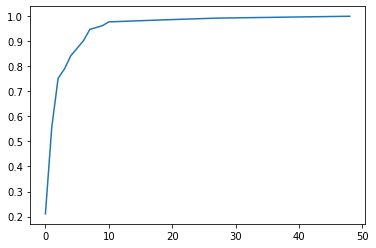

In [135]:
#plot indexes and fitness
plt.plot(indexes, fitness)